In [88]:
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [44]:
full_data = np.load("../data/mnist-data-hw3.npz")
data = full_data["training_data"]
data_labels = full_data["training_labels"]

In [45]:
pixel_data = data.reshape(data.shape[0], -1)
shaped_data = np.column_stack((pixel_data, data_labels))
pixel_data.shape, shaped_data.shape

((60000, 784), (60000, 785))

In [106]:
class LDA:
    def __init__(self, data):
        self.gausses = []
        for label in range(10):
            subset = data[data[:, -1] == label]
            subset = subset[:, 0:-1]
            gauss = MLEGaussian(subset=subset, digit=label, data_len=len(data))
            self.gausses.append(gauss)
        
        # calculate pooled covariance matrix
        pooled_cov_matrix = np.zeros((784, 784))
        for gauss in self.gausses:
            subpool = (len(gauss.subset) - 1) * gauss.cov_matrix
            pooled_cov_matrix = pooled_cov_matrix + subpool
        pooled_cov_matrix = pooled_cov_matrix / (len(data) - 10)
        
        # add regularization term so matrix is invertible
        regularization_term = 1e-5 * np.eye(pooled_cov_matrix.shape[0])
        self.pooled_cov_matrix = pooled_cov_matrix + regularization_term
        self.pooled_cov_matrix_inv = np.linalg.pinv(self.pooled_cov_matrix)
        
    def predict(self, X):
        if X.shape[1] == 785:
            X = X[:, 0:-1] 
            
        # matrix to store discriminant scores for each sample and class so we can vectorize prediction
        scores = np.zeros((X.shape[0], len(self.gausses)))
        
        for digit, gauss in enumerate(self.gausses):
            mu = gauss.mu
            pi_c = gauss.pi_c
            
            # Calculate discriminant score for all samples at once
            diff = X - mu

            # little out of order since we flattened mu in gaussian
            term1 = np.dot(X, self.pooled_cov_matrix_inv).dot(mu)  
            term2 = 0.5 * np.dot(mu.T, self.pooled_cov_matrix_inv).dot(mu)  
            log_pi_c = np.log(pi_c)

            scores[:, digit] = term1 - term2 + log_pi_c
            
        return np.argmax(scores, axis=1)

class MLEGaussian:
    def __init__(self, subset, digit, data_len):
        self.subset = subset
        self.digit = digit
        self.pi_c = len(subset) / data_len
        
        # find mean vector and covariance matrix
        self.mu = np.mean(self.subset, axis=0)
        self.cov_matrix = np.cov(self.subset, rowvar=False)
        
        # add regularization term to covariance matrix
        regularization_term = 1e-5 * np.eye(self.cov_matrix.shape[0])
        self.cov_matrix += regularization_term


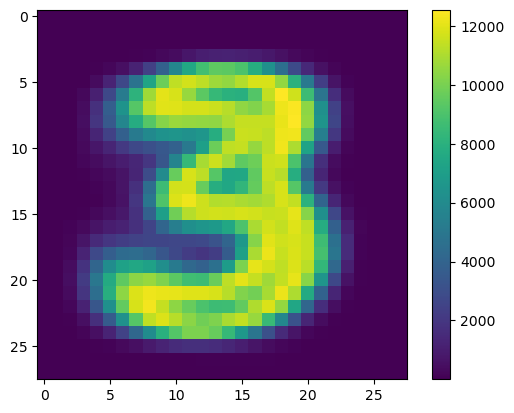

In [108]:
lda = LDA(shaped_data)
gausses = lda.gausses
threes = gausses[3]
cov_matrix = threes.cov_matrix
variances = np.diag(cov_matrix)
var_matrix = variances.reshape(28, 28)

plt.imshow(var_matrix, cmap='viridis')
plt.colorbar()

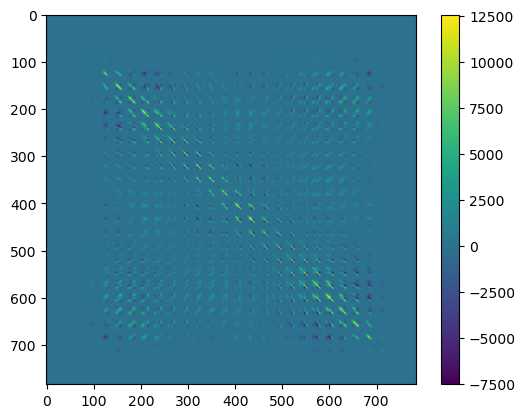

In [109]:
threes = gausses[3]
cov_matrix = threes.cov_matrix

plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(pixel_data, data_labels, test_size=10000, random_state=42)


In [111]:
training = np.column_stack((X_train, y_train))
lda = LDA(training)

predictions = lda.predict(X_test)
accuracy_score(y_test, predictions)

0.8626